<a href="https://colab.research.google.com/github/KamonohashiPerry/kamonohashiperry.com/blob/master/Apartment_classification_with_stacking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## README
SUUMOのマンション一覧ページからWebスクレイピングして取ってきたマンションの施設情報に、デザイナーズマンションかどうかの教師データをつけたものを用いて、デザイナーズマンションかどうかを分類しています。  

ColabでMeCabが使えるように色々と、以下に書かれている通りにインストールしてください。
施設情報に対して形態素解析を行い、それを特徴量としています。  

その特徴量に対してランダムフォレストを適用したものでの10holdsクロスバリデーションと
vecstackというモジュールを用いてスタッキングを行ったものでの10holdsクロスバリデーションの実行結果を載せています。

使い方などは参考文献に載っています。

In [0]:
!pip install vecstack

In [0]:
!pip install DocumentFeatureSelection

In [0]:
!pip install JapaneseTokenizer

In [0]:
!pip install neologdn

In [0]:
!pip install mojimoji

In [0]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from vecstack import stacking
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [0]:
corpus_data = pd.read_csv("https://raw.githubusercontent.com/KamonohashiPerry/kamonohashiperry.com/master/designers_apartment/designers_apartment.csv",encoding="utf-8")
corpus_data = corpus_data[~corpus_data.text.isna()].reset_index(drop=True)

In [0]:
# 形態素解析
import collections
import MeCab
import mojimoji
from string import digits

In [0]:
!apt-get -q -y install sudo file mecab libmecab-dev mecab-ipadic-utf8 git curl python-mecab

Reading package lists...
Building dependency tree...
Reading state information...
sudo is already the newest version (1.8.21p2-3ubuntu1).
libmecab-dev is already the newest version (0.996-5).
mecab is already the newest version (0.996-5).
mecab-ipadic-utf8 is already the newest version (2.7.0-20070801+main-1).
python-mecab is already the newest version (0.99.6-2).
curl is already the newest version (7.58.0-2ubuntu3.7).
file is already the newest version (1:5.32-2ubuntu0.2).
git is already the newest version (1:2.17.1-1ubuntu0.4).
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [0]:
remove_digits = str.maketrans('', '', digits)
 
tagger = MeCab.Tagger()
 
def nouns_extract(line):
    keyword=[]
    node = tagger.parseToNode(line).next
    while node:
        if node.feature.split(",")[0] == "名詞":
            keyword.append(node.surface)
        node = node.next
    keyword = str(keyword).replace("', '"," ")
    keyword = keyword.replace("\'","")
    keyword = keyword.replace("[","")
    keyword = keyword.replace("]","")
    return keyword

In [0]:
# 全角を半角にする
corpus_data["text_fixed"] =  list(map(lambda text: mojimoji.zen_to_han(text, kana=False) , corpus_data.text))
 
# 数字を除外する
corpus_data["text_fixed"] =  list(map(lambda text: text.translate(remove_digits) , corpus_data.text_fixed))
 
# デザイナーズという表現を除外する
corpus_data["text_fixed"] =  corpus_data.text_fixed.str.replace("デザイナーズ", "")

# 形態素解析する
corpus_data["text_wakati"] = list(map(lambda text:nouns_extract(text) , list(corpus_data.text_fixed)))

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
 
# word count feature
countvector = CountVectorizer(min_df=0.01, max_df=0.90)
matrix = countvector.fit_transform(corpus_data.text_wakati)
countvector.get_feature_names()[:10]
 
X = matrix
y = corpus_data.designer_flag.values
 
n_samples, n_features = X.shape
print(n_features)
 
random_state = np.random.RandomState(0)
classifier = RandomForestClassifier(random_state=random_state)
 

207


In [0]:
def classification_and_roc_analysis(k, classifier, X, y):
    import numpy as np
    from scipy import interp
    import matplotlib.pyplot as plt
    
    from pylab import rcParams
    rcParams['figure.figsize'] = 8,8

    from sklearn.model_selection import StratifiedKFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.ensemble import RandomForestClassifier
    
    # Classification and ROC analysis
    # Run classifier with cross-validation and plot ROC curves
    cv = StratifiedKFold(n_splits=k, random_state = 123)
    classifier = classifier

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

        i += 1
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [0]:
models = [
    
KNeighborsClassifier(n_neighbors=5,
                                     n_jobs=-1),
        
    
RandomForestClassifier(random_state=0, n_jobs=-1, 
                                          n_estimators=100, max_depth=3),
        
    
XGBClassifier(random_state=0, n_jobs=-1, learning_rate=0.1, 
                         n_estimators=100, max_depth=3)
]

In [0]:
S_train, S_test = stacking(models,                   
                                               X_train, y_train, X_test,   
                                               regression=False, 
                                               mode='oof_pred_bag', 
                                               needs_proba=False,
                                               save_dir=None, 
                                               metric=accuracy_score, 
                                               n_folds=10, 
                                               stratified=True,
                                               shuffle=True,  
                                               random_state=0,    
                                               verbose=2)

task:         [classification]
n_classes:    [2]
metric:       [accuracy_score]
mode:         [oof_pred_bag]
n_models:     [3]

model  0:     [KNeighborsClassifier]
    fold  0:  [0.86666667]
    fold  1:  [0.86666667]
    fold  2:  [0.84000000]
    fold  3:  [0.88000000]
    fold  4:  [0.84563758]
    fold  5:  [0.84563758]
    fold  6:  [0.87248322]
    fold  7:  [0.85135135]
    fold  8:  [0.87162162]
    fold  9:  [0.88513514]
    ----
    MEAN:     [0.86251998] + [0.01495129]
    FULL:     [0.86250838]

model  1:     [RandomForestClassifier]
    fold  0:  [0.82000000]
    fold  1:  [0.82000000]
    fold  2:  [0.82666667]
    fold  3:  [0.82666667]
    fold  4:  [0.83221477]
    fold  5:  [0.83221477]
    fold  6:  [0.82550336]
    fold  7:  [0.82432432]
    fold  8:  [0.82432432]
    fold  9:  [0.82432432]
    ----
    MEAN:     [0.82562392] + [0.00396726]
    FULL:     [0.82562039]

model  2:     [XGBClassifier]
    fold  0:  [0.87333333]
    fold  1:  [0.86000000]
    fold  2:  

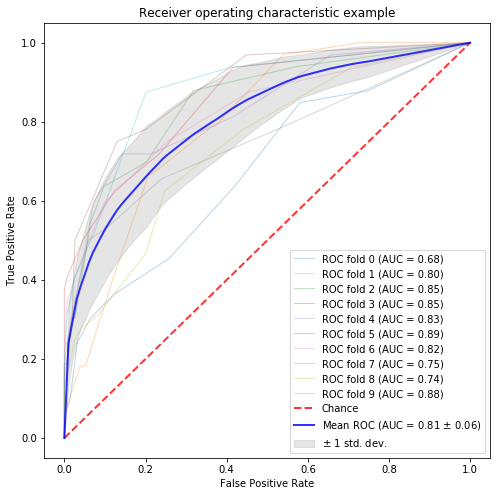

In [0]:
# No Stacking
# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X, y=y)

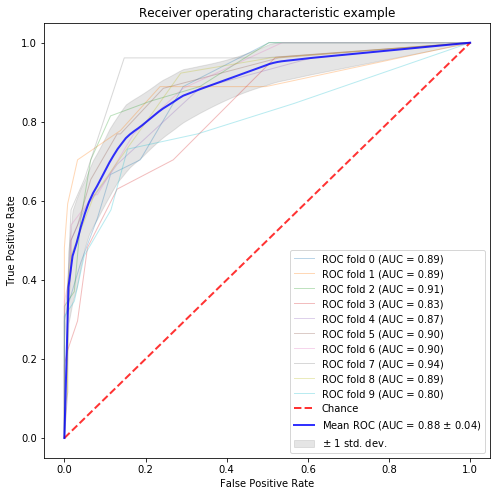

In [0]:
# Stacking
# classification and draw roc curve
classification_and_roc_analysis(k=10, classifier=classifier, X=X_train, y=y_train)

## Reference
+ Automate Stacking In Python How to Boost Your Performance While Saving Time  
https://towardsdatascience.com/automate-stacking-in-python-fc3e7834772e

+ Python package for stacking (machine learning technique)  
https://github.com/vecxoz/vecstack